In [1]:
import sys
import os
import math
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D


In [14]:
def simu_LISA_orbits():
    R=15#distance to sun
    E=np.array([R,0,0])
    E=E.reshape(-1,1)
    Delta_phi=-pi/6
    L=5#armlength
    
    #rotataion martix 
    M_r1=np.array([[np.cos(Delta_phi),np.sin(Delta_phi),0],[np.sin(Delta_phi),np.sin(Delta_phi),0],[0,0,1]])
    
    t=np.arange(0,361,1)
    t=t.reshape(-1,1)
    Omega=2*pi/t[-1]
    Phi=np.linspace(0,2*pi,361)
    Phi=Phi.astype(np.float64)
    #print(Phi.dtype)
    
    x_E=R*np.cos(Phi)
    y_E=R*np.sin(Phi)
    z_E=R*np.zeros((1,361))
    E=np.row_stack((x_E,y_E,z_E))
    t_v=np.array([R,0,0])
    t_v=t_v.reshape((-1,1))

    #rotation matrix for plane to plane
    M_r2=np.array([[np.cos(pi/3),0,-np.sin(pi/3)],[0,1,0],[np.sin(pi/3),0,np.cos(pi/3)]])
    
    #rotation matrix for spacecraft
    M_r3=np.array([[np.cos(-pi*2/3), -np.sin(-pi*2/3),0],[np.sin(-pi*2/3),np.cos(-pi*2/3),0],[0,0,1]])
    
    SC1=np.array([L/np.sqrt(3),0,0]).reshape(-1,1)
    SC1_path=np.zeros(np.shape(E)).reshape(3,-1)
    #print(SC1.shape)
    for i in range(0,len(Phi)):
        
        #rotation matrix for points belonging to LISA circle
        M_r4=np.array([[np.cos(Phi[i]),-np.sin(Phi[i]),0],[np.sin(Phi[i]),np.cos(Phi[i]),0],[0,0,1]])
        M_r4=M_r4.astype(np.float64)
        #rotation matrix of LISA triangle during one period
        M_r5=M_r4*np.array([[1,-1,1],[-1,1,1],[1,1,1]])
        M_r5=M_r5.astype(np.float64)
        #print(M_r1.shape,E.shape,M_r4.shape,M_r2.shape,M_r5.shape,SC1.shape)
        # print((M_r4@M_r2@M_r5@SC1).shape)
        # print((E[:,i].reshape(-1,1)).shape)
        # print((M_r1@(M_r4@M_r2@M_r5@SC1)).shape)
        SC1_path[:,i]=M_r1@(E[:,i])
        # print(SC1_path[:,i].shape,(M_r1@M_r4@M_r2@M_r5@SC1)[:,0].shape)
        # print(SC1_path[:,i].dtype)
        # print(M_r1.dtype,M_r4.dtype,M_r2.dtype,M_r5.dtype,SC1.dtype)
        # print((M_r1@M_r4@M_r2@M_r5@SC1).dtype)

        SC1_path[:,i]+=(M_r1@M_r4@M_r2@M_r5@SC1)[:,0]
    
    SC2_path=np.dot(np.linalg.inv(M_r3),SC1_path).reshape(3,-1)
    SC3_path=np.dot(M_r3,SC1_path).reshape(3,-1)
    
    #LISA circle
    C=np.zeros((3,len(Phi)))
    for i in range(0,len(Phi)):
        M_r4=np.array([[np.cos(Phi[i]),-np.sin(Phi[i]),0],[np.sin(Phi[i]),np.cos(Phi[i]),0],[0,0,1]])
        M_r4=M_r4.astype(np.float64)
        M_r5=M_r4*np.array([[1,-1,1],[-1,1,1,],[1,1,1]])
        M_r5=M_r5.astype(np.float64)
        
        C[:,i]=M_r1@(t_v+M_r2@M_r5@SC1)[:,0]

    C_total=np.zeros((3,len(Phi),len(Phi))).reshape(3,len(Phi),len(Phi))
    C_total[:,:,1]=C[:,:]#initial circle
    for n in range(1,len(Phi)):
        M_r4=np.array([[np.cos(Phi[i]),-np.sin(Phi[i]),0],[np.sin(Phi[i]),np.cos(Phi[i]),0],[0,0,1]])
        M_r4=M_r4.astype(np.float64)
        C_total[:,:,n]=np.dot(M_r4,C_total[:,:,1])

    #SC_inf and sup circle
    x_sup=x_E+(L*np.cos(pi/3))/np.sqrt(3)*np.cos(Phi)
    y_sup=y_E+(L*np.cos(pi/3))/np.sqrt(3)*np.sin(Phi)
    z_sup=z_E+(L*np.sin(pi/3))/np.sqrt(3)
    SC_sup=np.row_stack((x_sup,y_sup,z_sup))
    SC_sup=np.dot(M_r1,SC_sup)

    x_inf=x_E-(L*np.cos(pi/3))/np.sqrt(3)*np.cos(Phi)
    y_inf=y_E-(L*np.cos(pi/3))/np.sqrt(3)*np.sin(Phi)
    z_inf=z_E-(L*np.sin(pi/3))/np.sqrt(3)
    SC_inf=np.row_stack((x_inf,y_inf,z_inf))
    SC_inf=np.dot(M_r1,SC_inf)
    return Phi,E,SC1_path,SC2_path,SC3_path,C_total,SC_sup,SC_inf,R


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
#LISA animation
[Phi,E,SC1_path,SC2_path,SC3_path,C_total,SC_sup,SC_inf,R]=simu_LISA_orbits()

#compuational parameter
step=5
# Computational parameters
step = 5

# Display parameters
time_lapse = 0.1
title_text = 'Orbitography of space interferometer project LISA, following Earth in the solar system'
filename = 'LISA_orbitography.gif'
az = -75
el = 20

# Display settings
fig = plt.figure(figsize=(15, 7.5))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
orbit_bounds = False
LISA_relative_circular_orbit = False

frames = []

for k in range(0, len(Phi), step):
    ax.plot(E[0], E[1], E[2], color=[0, 0, 1], linewidth=3)
    # ... (similarly plot other paths)

    # ... (your other plotting logic)

    ax.set_xlim([-4*R/3, 4*R/3])
    ax.set_ylim([-4*R/3, 4*R/3])
    ax.set_zlim([-R/3, R/3])
    ax.axis('off')
    ax.view_init(elev=el, azim=az)
    ax.set_title(title_text, fontsize=16, color=[1, 1, 1])

    # Capture the current frame
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)

    plt.clf()

# Save frames as a gif
imageio.mimsave(filename, frames, duration=time_lapse)


<Figure size 1500x750 with 0 Axes>

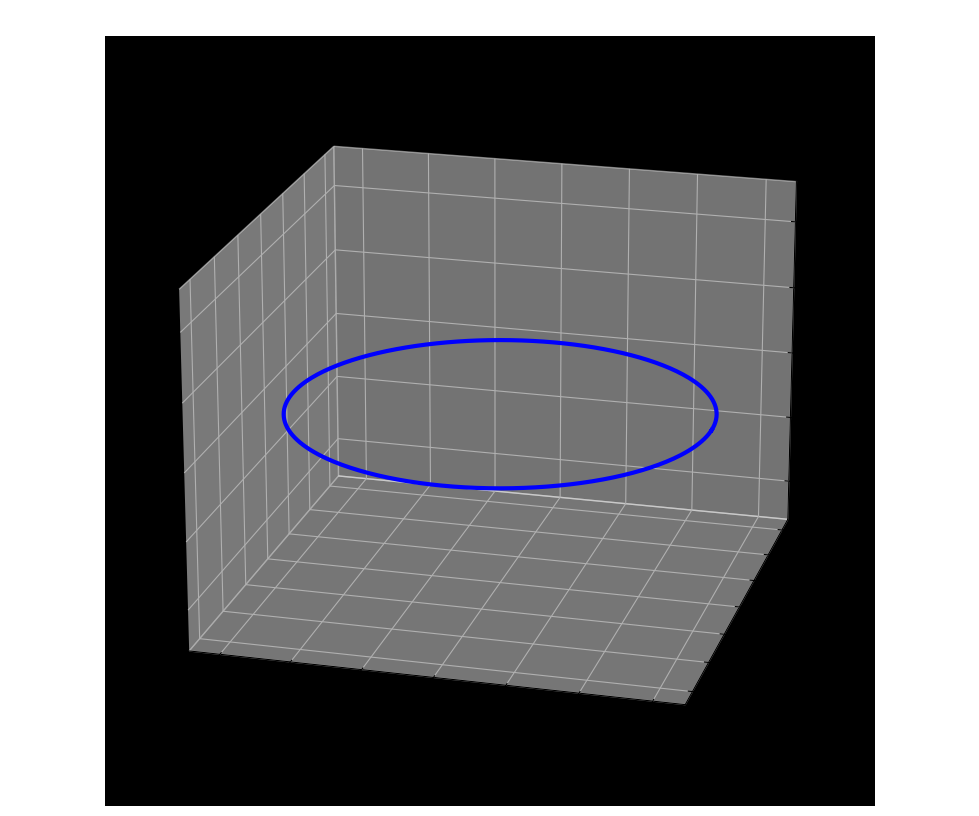

In [16]:
#LISA animation
[Phi,E,SC1_path,SC2_path,SC3_path,C_total,SC_sup,SC_inf,R]=simu_LISA_orbits()

#compuational parameter
step=5

#display parameter

import numpy as np
import matplotlib.pyplot as plt
import imageio

# Computational parameters
step = 5

# Display parameters
time_lapse = 0.1
title_text = 'Orbitography of space interferometer project LISA, following Earth in the solar system'
filename = 'LISA_orbitography.gif'
az = -75
el = 20

# Display settings
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
orbit_bounds = False
LISA_relative_circular_orbit = False

# Assuming Phi, E, Sp1path, Sp2path, Sp3path, Spinf, Spsup, C_total are already defined
# For the sake of this example, I'm not defining them here

images = []

for k in range(0, len(Phi), step):
    ax.plot(E[0, :], E[1, :], E[2, :], color='blue', linewidth=3)
    # ... (similarly plot other paths and points as in the MATLAB code)

    # Adjust view and other properties
    ax.view_init(elev=el, azim=az)
    ax.set_title(title_text, fontsize=16, color='white')
    # ... (set other properties)

    plt.pause(time_lapse)

    # Capture the current figure as an image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

    ax.clear()

# Save images as a gif
imageio.mimsave(filename, images, duration=time_lapse)

plt.close()


In [10]:
#test
R=10
Phi=np.linspace(0,2*pi,361)

M_r4=np.array([[np.cos(Phi[1]),-np.sin(Phi[1]),0],[np.sin(Phi[1]),np.cos(Phi[1]),0],[0,0,1]])
print(M_r4)

[[ 0.9998477  -0.01745241  0.        ]
 [ 0.01745241  0.9998477   0.        ]
 [ 0.          0.          1.        ]]


In [ ]:
a=np.row_stack((np.linspace(0,10,11).reshape(1,-1),np.linspace(1,11,11).reshape(1,-1),np.linspace(3,13,11).reshape(1,-1)))
b=a
M_r2=np.array([[np.cos(pi/3),0,-np.sin(pi/3)],[0,1,0],[np.sin(pi/3),0,np.cos(pi/3)]])
print(M_r2@np.array([1,2,3]).reshape(-1,1))
temp = M_r2@(a[:,3]+np.array([1,2,3]).reshape(-1,1))
b[:,3]= (M_r2@(a[:,3]+M_r2@M_r2@np.array([1,2,3]).reshape(-1,1)))[:,0]
print(b)
print(M_r2)

[[-2.09807621]
 [ 2.        ]
 [ 2.3660254 ]]
[[ 0.          1.          2.         -2.09807621  4.          5.
   6.          7.          8.          9.         10.        ]
 [ 1.          2.          3.          5.          5.          6.
   7.          8.          9.         10.         11.        ]
 [ 3.          4.          5.          1.09807621  7.          8.
   9.         10.         11.         12.         13.        ]]
[[ 0.5        0.        -0.8660254]
 [ 0.         1.         0.       ]
 [ 0.8660254  0.         0.5      ]]


In [ ]:
np.zeros((1,len(x_E)))

array([[0.]])

In [ ]:
print(np.linspace(0,10

[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.        ]


In [ ]:
E=np.array([[1,0,0],[2,0,0]])

s=np.arange(0,3)
print(np.cos(s))
A=np.row_stack((np.cos(s),np.sin(s),np.sin(s)))
A=np.cos(s)
B=np.diag(np.array([1,1,1]))
n,_=np.shape(np.array([[np.cos(pi/3),0,-np.sin(pi/3)],[0,1,0],[np.sin(pi/3),0,np.cos(pi/3)],[0,0,0]]))

print(A*B,np.dot(A,B))
print(np.dot(B,B,B))

[ 1.          0.54030231 -0.41614684]
[[ 1.          0.         -0.        ]
 [ 0.          0.54030231 -0.        ]
 [ 0.          0.         -0.41614684]] [ 1.          0.54030231 -0.41614684]
[[1 0 0]
 [0 1 0]
 [0 0 1]]
